In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import vmo
import vmo.VMO.utility as vutils
import vmo.analysis as van
import librosa 
import numpy as np
import pretty_midi
import sklearn.preprocessing as pre

import matplotlib.pyplot as plt 

%matplotlib inline

In [3]:
midi_file = 'midifiles/now_s_the_time.mid'
midi = pretty_midi.PrettyMIDI(midi_file) 

In [4]:
print midi.instruments

[Instrument(program=32, is_drum=False, name="Bass    (BB) "), Instrument(program=0, is_drum=True, name="Drums   (BB) "), Instrument(program=0, is_drum=False, name="Piano   (BB) ")]


In [5]:
# chroma matrix - the energy in each semitone across octaves
chroma_midi = midi.get_chroma(times=np.arange(0, midi.get_end_time(), 1/25.0))

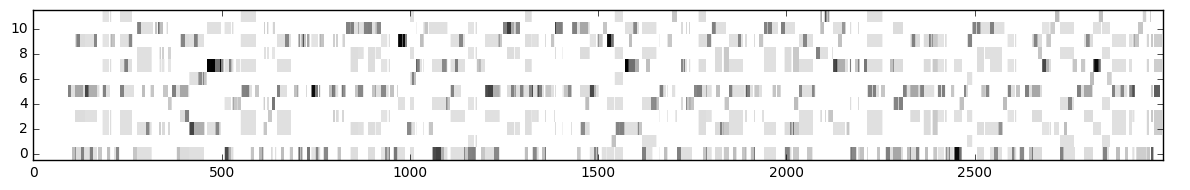

In [6]:
plt.figure(figsize=(12,2))
plt.imshow(chroma_midi, origin='lower', aspect='auto', interpolation='nearest', cmap='Greys')
plt.tight_layout()

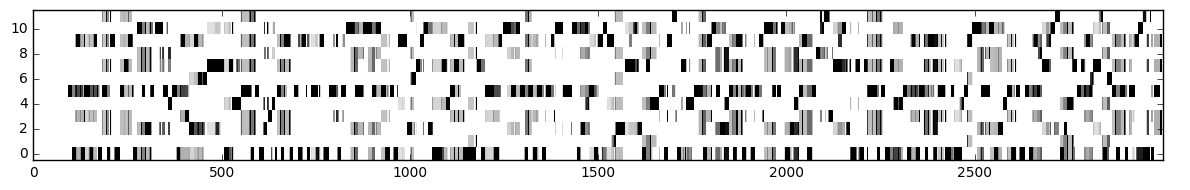

In [7]:
chroma_midi = pre.maxabs_scale(chroma_midi, axis=0)+np.finfo(float).eps

plt.figure(figsize=(12,2))
plt.imshow(chroma_midi, origin='lower', aspect='auto', interpolation='nearest', cmap='Greys')
plt.tight_layout()

In [8]:
midi_chroma_length = midi.get_end_time()/ chroma_midi.shape[1]
beat_positions = midi.get_beats().tolist()
beat_positions.append(midi.get_end_time())
midi_chroma_beat_indeces = []
midi_chroma_idx = 0

In [9]:
for i in range(chroma_midi.shape[1]):

    if i * midi_chroma_length >= beat_positions[midi_chroma_idx]:
        midi_chroma_beat_indeces.append(i)
        midi_chroma_idx += 1

    if midi_chroma_idx >= len(beat_positions):
        print "!!!"
        break

In [10]:
chroma_midi_beat = librosa.feature.sync(chroma_midi, midi_chroma_beat_indeces, aggregate=np.mean)

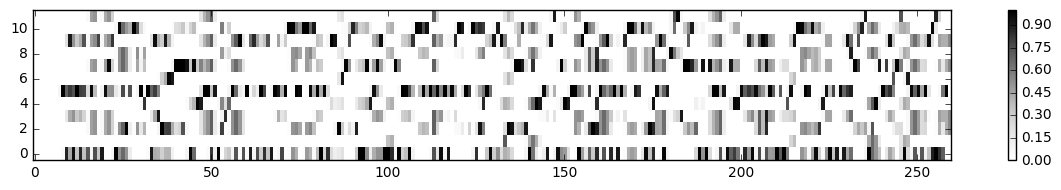

In [11]:
plt.figure(figsize=(12,2))
plt.imshow(chroma_midi_beat, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.Greys)
plt.colorbar()
plt.tight_layout()
plt.show()

In [12]:
r = (0, 2.01, 0.01)
threshold = vmo.find_threshold(chroma_midi_beat.T, r=r, dim=12,
                               dfunc='other', 
                               dfunc_handle=vutils.tonnetz_dist
                              )

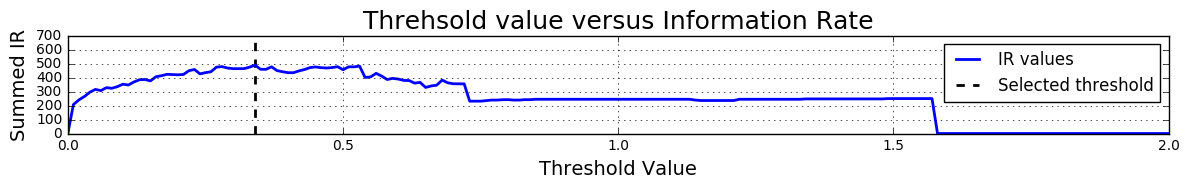

In [13]:
ideal_t = threshold[0][1]
x_t = [i[1] for i in threshold[1]]
y_t = [i[0] for i in threshold[1]]

plt.figure(figsize=(12,2))
plt.plot(x_t, y_t, linewidth = 2)
plt.hold('on')
plt.vlines(ideal_t, 0.0, 700, colors='k',linestyle = 'dashed',linewidth = 2)
plt.grid('on')
plt.legend(['IR values', 'Selected threshold'], loc=1)
plt.title('Threhsold value versus Information Rate', fontsize = 18)
plt.xlabel('Threshold Value',fontsize = 14)
plt.ylabel('Summed IR', fontsize = 14)
plt.tight_layout()


Codes not generated. Generating codes with encode().


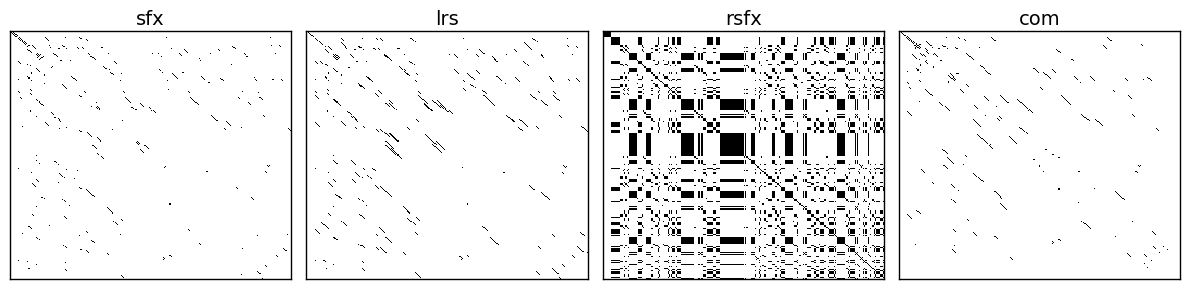

In [14]:
midi_vmo = vmo.build_oracle(chroma_midi_beat.T, flag='a', threshold=ideal_t, dim=12,
                            dfunc='other', 
                            dfunc_handle=vutils.tonnetz_dist
                            )
methods = ['sfx', 'lrs', 'rsfx', 'com']

plt.figure(figsize = (12,3))
for i,m in enumerate(methods):
    recurrence_vmo = van.create_selfsim(midi_vmo, method=m)
    plt.subplot(1,len(methods),i+1)
    plt.imshow(recurrence_vmo, interpolation='nearest', aspect='auto', cmap='Greys')
    plt.title(m, fontsize=14)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

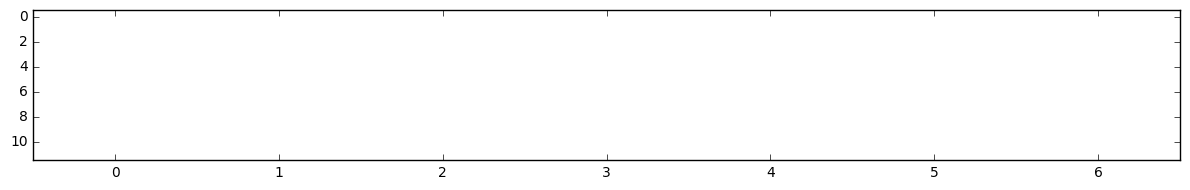

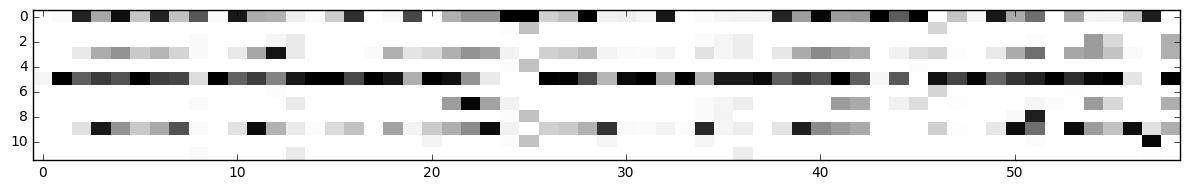

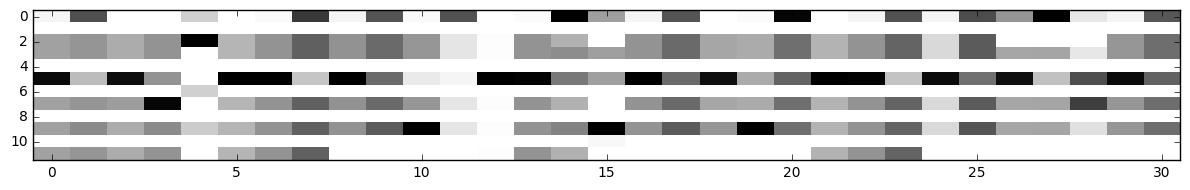

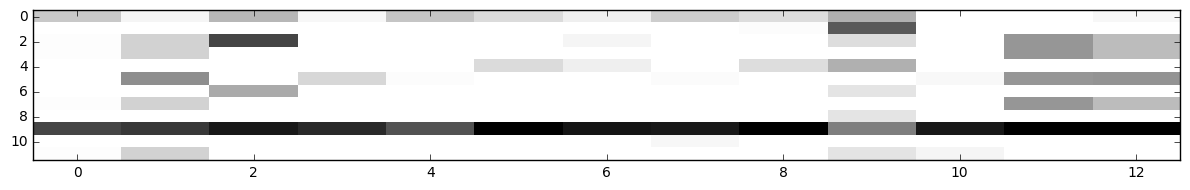

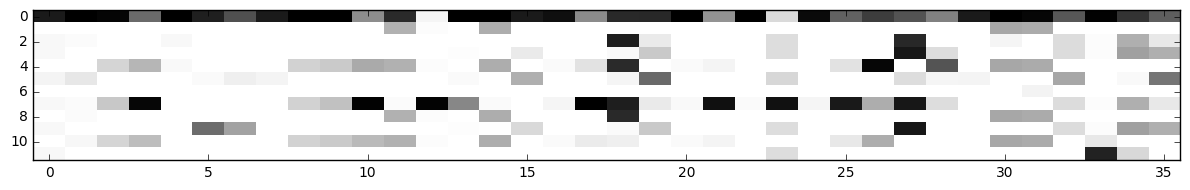

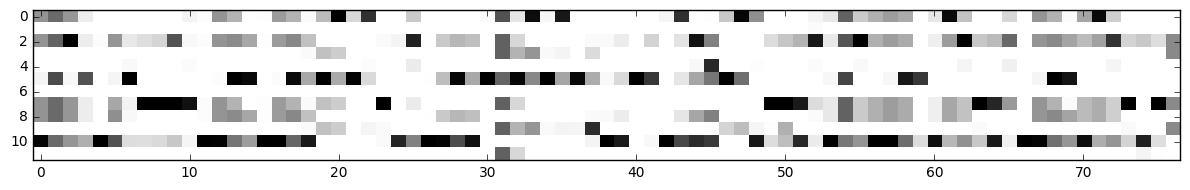

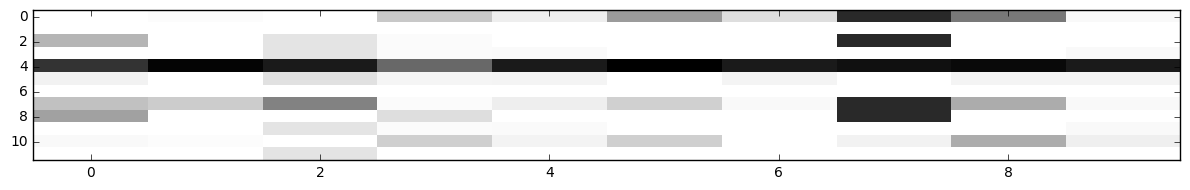

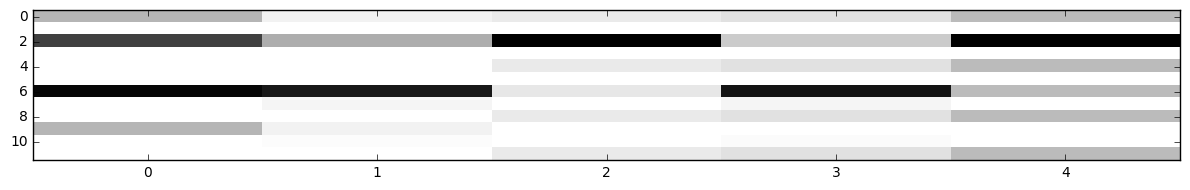

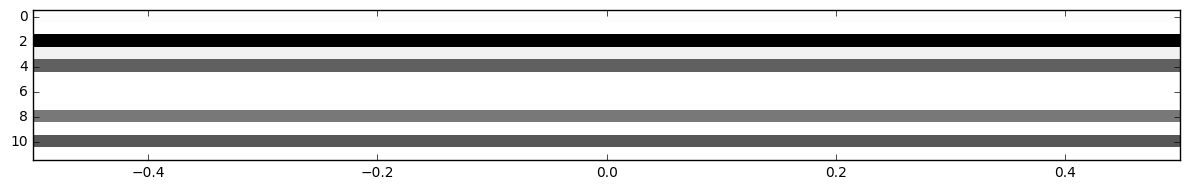

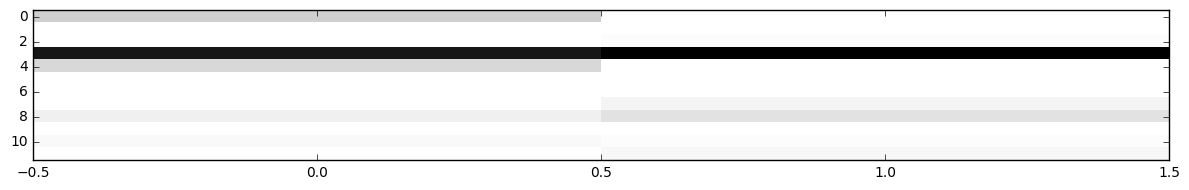

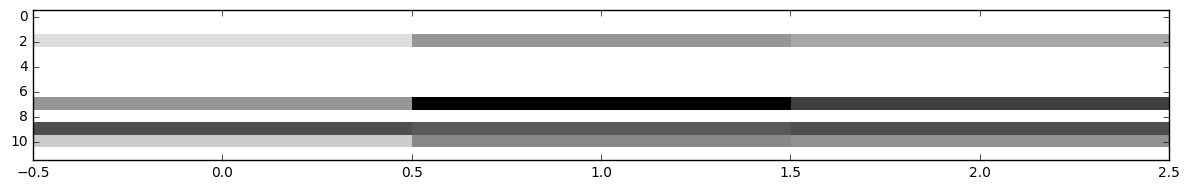

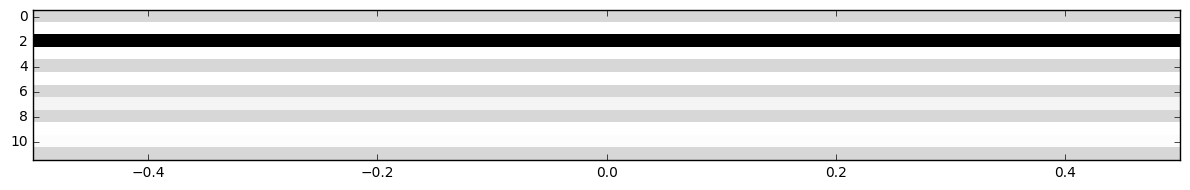

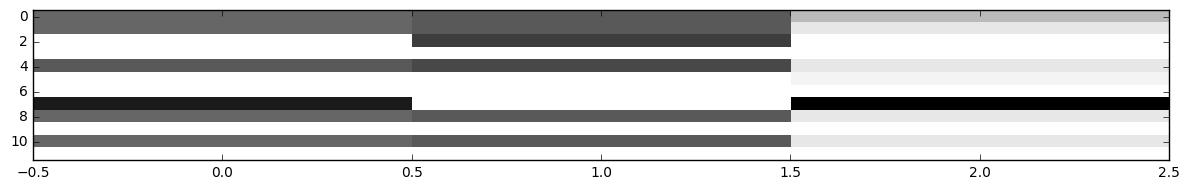

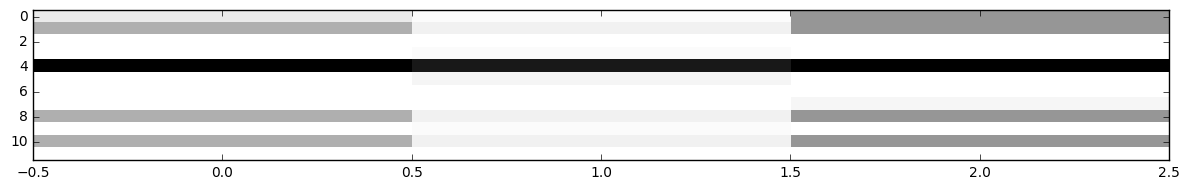

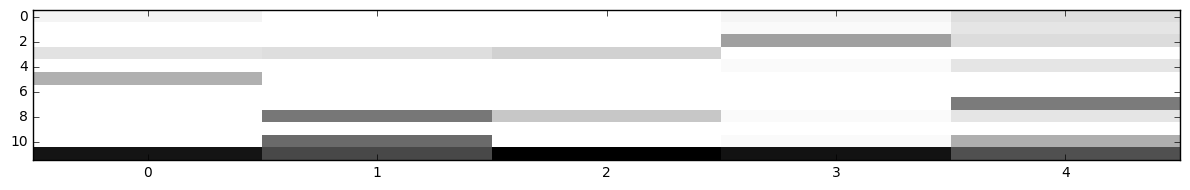

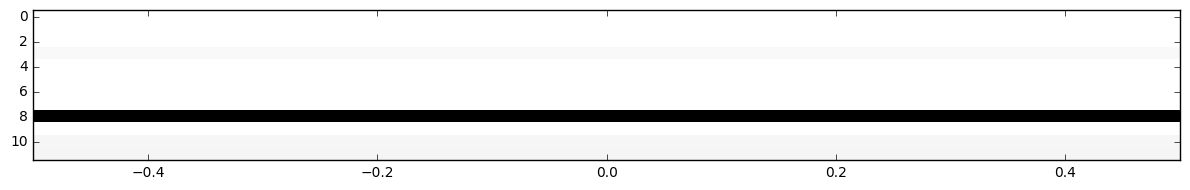

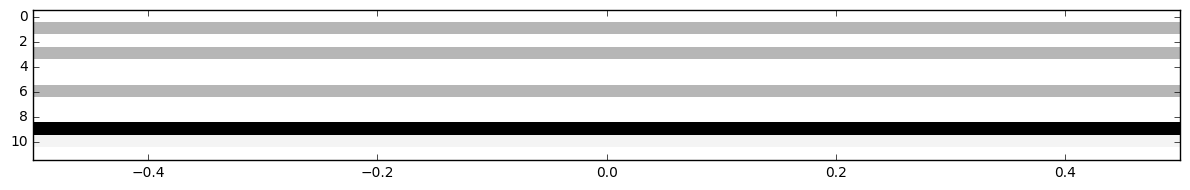

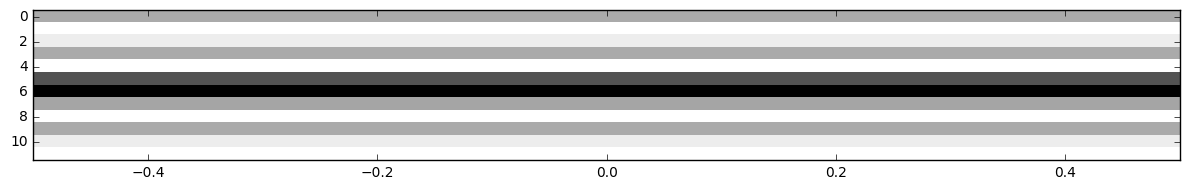

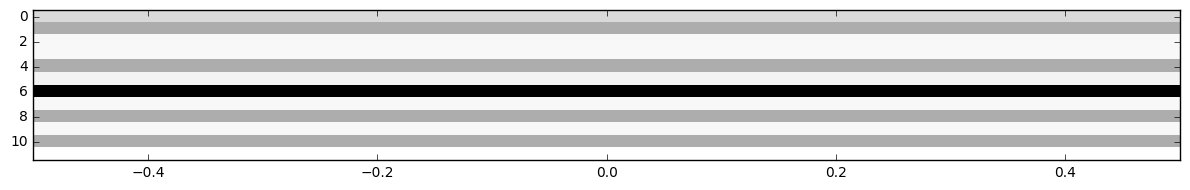

In [15]:
for c in midi_vmo.latent:
    cluster_mat = chroma_midi_beat.T[np.array(c)-1]
    plt.figure(figsize=(12,2))
    plt.imshow(cluster_mat.T, aspect='auto', interpolation='nearest', cmap='Greys')
    plt.tight_layout()